## Introduction

This notebook describes using the AWS Step Functions Data Science SDK to create and manage workflows. The Step Functions SDK is an open source library that allows data scientists to easily create and execute machine learning workflows using AWS Step Functions and Amazon SageMaker. For more information, see the following.
* [AWS Step Functions](https://aws.amazon.com/step-functions/)
* [AWS Step Functions Developer Guide](https://docs.aws.amazon.com/step-functions/latest/dg/welcome.html)
* [AWS Step Functions Data Science SDK](https://aws-step-functions-data-science-sdk.readthedocs.io)

In this notebook we will use the SDK to create steps, link them together to create a workflow, and execute the workflow in AWS Step Functions. 

In [33]:
# import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install -qU awscli boto3 "sagemaker>=2.0.0"
# !{sys.executable} -m pip install -qU "stepfunctions>=2.0.0"
# !{sys.executable} -m pip show sagemaker stepfunctions

## Prequisite 

It is assumed that lambda functions for checking if model already exist or not and required IAM roles for Sagemaker, Step function is already created. <br/>
In this notebook we are going to use Step Functions SDK build-up for Sagemaker


## 1. Preprocessing logic script

Below is the preprocessing logic script which we will upload on S3 it will be used in preprocessing job. These scripts are the logic script which we have generated for preprocessing activities. Upload it on S3 and then we can use it as the parameter.

FileNotFoundError: [Errno 2] No such file or directory: '/titanic/train/train.csv'

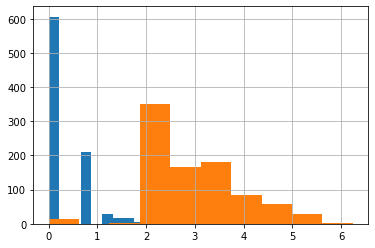

In [10]:
%%writefile Titanic-preprocessing-linear-learner-script.py
# Importing required library
# Importing required library
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import glob
# you can put any value here according to your situation
chunksize = 10000
from sklearn import preprocessing
path = r'/opt/ml/processing/input' # Input path
all_files = glob.glob(path + "/*.csv")
#read them into pandas
df_list = [pd.read_csv(filename) for filename in all_files]
data = pd.concat(df_list)
df = data.copy()
#change this as per the data set
df.drop(columns=['Unnamed: 0', 'url', 'region', 'region_url', 'VIN', 'size', 'image_url', 'description', 'state', 'lat', 'long','posting_date'], inplace=True)
imr = SimpleImputer(strategy='mean')
imr = imr.fit(df[['odometer']])
imputed_data = imr.transform(df[['odometer']])
df['odometer'] = pd.DataFrame(imputed_data)
def encode_features(dataframe):
    result = dataframe.copy()
    encoders = {}
    for column in result.columns:
        if column in['year','odometer','id']:
            result[column]=result[column]
            #result[column].fillna(2018)
        elif result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

encoded_df, encoders = encode_features(df.astype(str)) 
encoded_df=encoded_df[encoded_df['year']!='nan']
#split train test , change if diff split is required
train_data, validation_data, test_data = np.split(encoded_df.sample(frac=1, random_state=1729), [int(0.7 * len(encoded_df)), int(0.9*len(encoded_df))]) # Splitting dataset 
train_data=train_data.drop(columns=['id'])#id is used for ground truth, if there is no id column in data create custom and use that
train_data.to_csv('/opt/ml/processing/train/train.csv', index=False, header=False) # train data
train_data.to_csv('/opt/ml/processing/trainbase/train_baseline.csv', index=False, header=True) # baseline data
validbsline_data=validation_data.copy()
validation_data=validation_data.drop(columns=['id'])#id is used for ground truth, if there is no id column in data create custom and use that
validation_data.to_csv('/opt/ml/processing/validation/validation_data.csv', index=False, header=False) # validation data
validbsline= validbsline_data.drop(columns=['price']) # removing cloumn where we have to do predictions
validbsline.to_csv('/opt/ml/processing/baselinemodeldrift/baselinemodeldrift.csv', index=False, header=False)
#validation data without label---one set
groundtrth=validbsline_data[['id','price']]#ground truth data should/only have Id,TargetVal colmun to corelate ground truth with predicted values 
groundtrth.to_csv('/opt/ml/processing/groundtruth/groundtruth.csv', index=False, header=True)
#ground truth (only label and ID)--2nd set
test_data = test_data.iloc[:,1:] # removing cloumn where we have to do predictions
test_data.to_csv('/opt/ml/processing/test/test.csv', index=False, header=False) # test data 

In [12]:
train_data.to_csv('train.csv', index=False, header=False) # train data

In [2]:
encoded_df

NameError: name 'encoded_df' is not defined

## 2. Parameter

Below are the list of paramters which we have to change inorder to run below sdk


In [3]:
import sagemaker

In [36]:
v_workflow_execution_role = "arn:aws:iam::525102048888:role/poc-sagemaker-step-functi-MachineLearningWorkflowE-1XFI2UPRXFTXE" # Step function IAM role ARN
v_preprocessing_iam_role = "arn:aws:iam::525102048888:role/service-role/AmazonSageMaker-ExecutionRole-20191105T125227" # IAM role for preprocessing container
v_lambda_execution_role = "arn:aws:iam::525102048888:role/poc-sagemaker-step-functi-LambaForDataGenerationEx-PKONGQTFWLRF"
v_preprocessing_instance_type = "ml.m5.xlarge" # Instance type for preprocessing container it changes as per workload
v_s3_input_bucket = "ds-mlops-dev" # S3 bucket for input and output data
v_prefix_for_input_data = "data/input/inputdata.csv"  # Prefix where data is stored
v_prefix_for_code_location = "code/ds-mlops-preprocessing_linear-learner_script.py" # prefix where code is stored
v_lambda_function_name = "ds-mlops-linear-learner-lambda-test" # Name of lambda function for triggering training pipeline.
v_region = 'us-east-1' # AWS region
v_model_container = sagemaker.image_uris.retrieve('linear-learner', v_region) # Linear conatiner
v_train_instance_type = "ml.m5.xlarge" # Instance type for training
v_validation_scoring_instance_type = "ml.m5.large" # Instance type for batch scoring
v_model_name = "ds-mlops-linear-learner-02" # Name of DS_MLOPS model to be kept
# VV added after design review
v_threshold=3000
v_prefix_for_train_lambda="code/query_training_status.zip"
##
sec_groups = ["sg-044e0e7ce4f5721c0"]
subnets = ["subnet-0cf0e3f46326aa259",
           "subnet-0156b7f5500cf0b78",
           "subnet-032420199163cff9b"]

## 3 Import the required modules from the SDK and uploading code to s3

In [37]:
import stepfunctions
import logging

from stepfunctions.steps import *
from stepfunctions.workflow import Workflow
from stepfunctions import steps
from stepfunctions.inputs import ExecutionInput
from sagemaker.processing import Processor,ProcessingInput, ProcessingOutput
import uuid
import sagemaker
from sagemaker.inputs import TrainingInput
import boto3
from sagemaker.network import NetworkConfig

stepfunctions.set_stream_logger(level=logging.INFO)

In [38]:
!aws s3 cp ds-mlops-preprocessing-linear-learner-script.py s3://$v_s3_input_bucket/$v_prefix_for_code_location # Uploading preprocessing code on s3

upload: ./ds-mlops-preprocessing-linear-learner-script.py to s3://ds-mlops-dev/code/ds-mlops-preprocessing_linear-learner_script.py


#added below lambda for query training status to read metric values

In [39]:
%%writefile query_training_status.py
import boto3
import logging
import json

logger = logging.getLogger()
logger.setLevel(logging.INFO)
sm_client = boto3.client('sagemaker')

#Retrieve transform job name from event and return transform job status.
def lambda_handler(event, context):

    if ('TrainingJobName' in event):
        job_name = event['TrainingJobName']

    else:
        raise KeyError('TrainingJobName key not found in function input!'+
                      ' The input received was: {}.'.format(json.dumps(event)))

    #Query boto3 API to check training status.
    try:
        response = sm_client.describe_training_job(TrainingJobName=job_name)
        logger.info("Training job:{} has status:{}.".format(job_name,
            response['TrainingJobStatus']))

    except Exception as e:
        response = ('Failed to read training status!'+ 
                    ' The training job may not exist or the job name may be incorrect.'+ 
                    ' Check SageMaker to confirm the job name.')
        print(e)
        print('{} Attempted to read job name: {}.'.format(response, job_name))

    #We can't marshall datetime objects in JSON response. So convert
    #all datetime objects returned to unix time.
    for index, metric in enumerate(response['FinalMetricDataList']):
        metric['Timestamp'] = metric['Timestamp'].timestamp()

    return {
        'statusCode': 200,
        'trainingMetrics': response['FinalMetricDataList']
    }


Overwriting query_training_status.py


In [40]:
## VV added after review
! zip query_training_status.zip query_training_status.py

updating: query_training_status.py (deflated 55%)


In [41]:
## VV added after review
! aws s3 cp query_training_status.zip s3://$v_s3_input_bucket/$v_prefix_for_train_lambda

upload: ./query_training_status.zip to s3://ds-mlops-dev/code/query_training_status.zip


In [42]:
## VV added after review
function_name = 'LinearLearnerQuery-training-status'
try:
    lambda_client = boto3.client('lambda')
    response = lambda_client.create_function(
        FunctionName=function_name,
        Runtime='python3.7',
        Role=v_lambda_execution_role,
        Handler='query_training_status.lambda_handler',
        Code={
            'S3Bucket':v_s3_input_bucket,
            'S3Key': '{}'.format(v_s3_input_bucket)
        },
        Description='Queries a SageMaker training job and return the results.',
        Timeout=15,
        MemorySize=128
    )
except:
    print("exception")

exception


## 4. Create workflow

In the following cell, you will define the step that you will use in our first workflow.  Then you will create, visualize and execute the workflow. 

Steps relate to states in AWS Step Functions. For more information, see [States](https://docs.aws.amazon.com/step-functions/latest/dg/concepts-states.html) in the *AWS Step Functions Developer Guide*. For more information on the AWS Step Functions Data Science SDK APIs, see: https://aws-step-functions-data-science-sdk.readthedocs.io. 

## 4.1 Creating Pre-Processing step

In [43]:
processor = Processor(image_uri='683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.20.0-cpu-py3',
                     role=v_preprocessing_iam_role,
                     instance_count=1,
                     instance_type=v_preprocessing_instance_type,
                      network_config = NetworkConfig(security_group_ids = sec_groups, subnets = subnets))

In [44]:
input_data = "s3://{}/{}".format("poc-sagemaker-step-function-bucketformodelanddata-iip9wy7qh0y0","vci/data/input/vehicles.csv")
input_code = "s3://{}/{}".format(v_s3_input_bucket,v_prefix_for_code_location)
output_data = "s3://{}/{}".format(v_s3_input_bucket,"preprocess-data")

inputs = [
    ProcessingInput(
        source=input_data, destination="/opt/ml/processing/input", input_name="input"
    ),
    ProcessingInput(
        source=input_code,
        destination="/opt/ml/processing/input/code",
        input_name="code",
    ),
]

outputs = [
    ProcessingOutput(
        source="/opt/ml/processing/train",
        destination="{}/{}".format(output_data,"train"),
        output_name="train_data",
    ),
    ProcessingOutput(
        source="/opt/ml/processing/test",
        destination="{}/{}".format(output_data, "test"),
        output_name="test_data",
    ),
    ProcessingOutput(
        source="/opt/ml/processing/validation",
        destination="{}/{}".format(output_data, "validation"),
        output_name="validation_data",
    )
]

In [45]:
print(input_data)

s3://poc-sagemaker-step-function-bucketformodelanddata-iip9wy7qh0y0/vci/data/input/vehicles.csv


In [46]:
# Generate unique names for Pre-Processing Job, Training Job, and Model Evaluation Job for the Step Functions Workflow
training_job_name = "linear-learner-training-{}".format(
    uuid.uuid1().hex
)  # Each Training Job requires a unique name
preprocessing_job_name = "linear-learner-preprocessing-{}".format(
    uuid.uuid1().hex
)  # Each Preprocessing job requires a unique name,
evaluation_job_name = "linear-learner-evaluation-{}".format(
    uuid.uuid1().hex
)  # Each Evaluation Job requires a unique name
scoring_job_name = "linear-learner-score-{}".format(
    uuid.uuid1().hex
)  # Each Evaluation Job requires a unique name

In [47]:
# SageMaker expects unique names for each job, model and endpoint.
# If these names are not unique the execution will fail. Pass these dynamically for each execution using placeholders.

##VV updated after review

execution_input = ExecutionInput(
    schema={
        "PreprocessingJobName": str,
        "TrainingJobName": str,
        "EvaluationProcessingJobName": str,
        "ModelName": str,
        "EndPointConfig":str,
        "EndpointName":str,
        "ScoreJobName":str
    }
)

In [48]:
preprocessing_step = ProcessingStep(
    state_id='Pre-processing', 
    processor=processor,
    job_name=execution_input["PreprocessingJobName"], 
    inputs=inputs, 
    outputs=outputs, 
    experiment_config=None, 
    container_entrypoint=["python3", "/opt/ml/processing/input/code/ds-mlops-preprocessing_linear-learner_script.py"], # DS needs to change this directory /path
    wait_for_completion=True
)

## 4.2 Train trigger lambda function (Check if model with same name exists)

In the following cell, we define a lambda step that will invoke the previously created lambda function as part of our Step Function workflow. See [LambdaStep](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/compute.html#stepfunctions.steps.compute.LambdaStep) in the AWS Step Functions Data Science SDK documentation to learn more.

In [49]:
client = boto3.client('sagemaker') # getting sagemaker client 
try:
    client.delete_model(
        ModelName=v_model_name # delete if some model exist with this name
    )
except:
    pass

In [50]:
lambda_step = compute.LambdaStep(
    'Start Training',
    parameters={  
        "FunctionName": v_lambda_function_name
    }
)

In [51]:
##VV added after review
lambda_step_acc = compute.LambdaStep(
    'Query Training Results',
    parameters={  
        "FunctionName": function_name,
        'Payload':{
            "TrainingJobName.$": '$.TrainingJobName'
        }
    }
)

In [52]:
##VV added after review
check_accuracy_step = steps.states.Choice(
    'RMSE < Threshold'
)

In [53]:
##VV added after review
fail_step = steps.states.Fail(
    'Model Accuracy Too Low',
    comment='Validation accuracy lower than threshold'
)

## 4.3 Train model

### Create a SageMaker Training Step 

In the following cell, we create the training step and pass the estimator we defined above. See  [TrainingStep](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.sagemaker.TrainingStep) in the AWS Step Functions Data Science SDK documentation to learn more.

In [54]:
sess = sagemaker.Session()
training_output = 's3://{}/models'.format(v_s3_input_bucket) # model output locations
linear = sagemaker.estimator.Estimator(v_model_container,
                                       v_preprocessing_iam_role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m5.xlarge',
                                       output_path=training_output,
                                       sagemaker_session = sess,
                                       security_group_ids=sec_groups,
                                       subnets=subnets)

linear.set_hyperparameters(epochs = 50,
                           l1 = 0.00035080090763972647,
                           learning_rate = 0.000199542496841376,
                           mini_batch_size = 512,
                           predictor_type = "regressor")

In [55]:
training_step = TrainingStep(
    'Model Training(linear)', 
    estimator=linear,
    data={
        'train': TrainingInput("{}/{}".format(output_data,"train"), content_type='text/csv'),
        'validation': TrainingInput("{}/{}".format(output_data, "validation"), content_type='text/csv')
    },
    job_name=execution_input['TrainingJobName'],
    wait_for_completion=True
)

## 4.4 Create a Model

In the following cell, we define a model step that will create a model in Amazon SageMaker using the artifacts created during the TrainingStep. See  [ModelStep](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.sagemaker.ModelStep) in the AWS Step Functions Data Science SDK documentation to learn more.

The model creation step typically follows the training step. The Step Functions SDK provides the [get_expected_model](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.sagemaker.TrainingStep.get_expected_model) method in the TrainingStep class to provide a reference for the trained model artifacts. Please note that this method is only useful when the ModelStep directly follows the TrainingStep.

In [56]:
model_step = ModelStep(
    'Save Model',
    model=training_step.get_expected_model(),
    model_name=execution_input['ModelName'],
    result_path='$.ModelStepResults'
)

## 4.5 Create a batch transform step

Now once all the above steps are done we will perform scoring on a small data set to see all the components are working fine

In [57]:
from sagemaker.inputs import TransformInput

batch_scoring = TransformStep(
    state_id="validation-step",
    job_name=execution_input['ScoreJobName'],
    transformer=linear.transformer(instance_count=1,
                                instance_type=v_validation_scoring_instance_type),
    data="{}/{}".format(output_data, "test"), # location for test data
    model_name=execution_input['ModelName'],
    content_type="text/csv"
)

# Create End point config and end point step

In [58]:
##VV added after review
endpoint_config_step = steps.EndpointConfigStep(
    "Create Model Endpoint Config",
    endpoint_config_name=execution_input['EndPointConfig'],
    model_name=execution_input['ModelName'],
    initial_instance_count=1,
    instance_type='ml.m4.xlarge'
)

In [59]:
##VV added after review
endpoint_step = steps.EndpointStep(
    'Update Model Endpoint',
    endpoint_name=execution_input['EndpointName'],
    endpoint_config_name=execution_input['EndPointConfig'],
    update=False
)

In [60]:
##VV added after review
threshold_rule = steps.choice_rule.ChoiceRule.NumericLessThan(variable=lambda_step.output()['Payload']['trainingMetrics'][0]['Value'], value=v_threshold)
check_accuracy_step.add_choice(rule=threshold_rule, next_step=endpoint_config_step)
check_accuracy_step.default_choice(next_step=fail_step)

In [61]:
##VV added after review
endpoint_config_step.next(endpoint_step)

Update Model Endpoint EndpointStep(resource='arn:aws:states:::sagemaker:createEndpoint', parameters={'EndpointConfigName': <stepfunctions.inputs.placeholders.ExecutionInput object at 0x7f711b461940>, 'EndpointName': <stepfunctions.inputs.placeholders.ExecutionInput object at 0x7f711b33dc50>}, type='Task')

## 4.6 Chain together steps for the basic path

The following cell links together the steps you've created into a sequential group called `basic_path`. We will chain a single step to create our basic path. See [Chain](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/states.html#stepfunctions.steps.states.Chain) in the AWS Step Functions Data Science SDK documentation.

After chaining together the steps for the basic path, in this case only one step, we will visualize the basic path.

In [62]:
# First we chain the start pass state,preprocessing_step,
basic_path=Chain([preprocessing_step,
                  training_step,
                  model_step,
                  lambda_step_acc,
                  check_accuracy_step])

## 4.7 Define the workflow instance

The following cell defines the [workflow](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/workflow.html#stepfunctions.workflow.Workflow) with the path we just defined.

After defining the workflow, we will render the graph to see what our workflow looks like.

In [63]:
# Next, we define the workflow
basic_workflow = Workflow(
    name="ds-mlops-dev-linear-learner-step-function",
    definition=basic_path,
    role=v_workflow_execution_role
)

#Render the workflow
basic_workflow.render_graph()

## 4.8 Review the Amazon States Language code for your workflow

The following renders the JSON of the [Amazon States Language](https://docs.aws.amazon.com/step-functions/latest/dg/concepts-amazon-states-language.html) definition of the workflow you created. 

In [64]:
print(basic_workflow.definition.to_json(pretty=True)) # From this json we would be leveraging the codes to create the Cloud Formation parameterized template...

{
    "StartAt": "Pre-processing",
    "States": {
        "Pre-processing": {
            "Resource": "arn:aws:states:::sagemaker:createProcessingJob.sync",
            "Parameters": {
                "ProcessingJobName.$": "$$.Execution.Input['PreprocessingJobName']",
                "ProcessingInputs": [
                    {
                        "InputName": "input",
                        "AppManaged": false,
                        "S3Input": {
                            "S3Uri": "s3://poc-sagemaker-step-function-bucketformodelanddata-iip9wy7qh0y0/vci/data/input/vehicles.csv",
                            "LocalPath": "/opt/ml/processing/input",
                            "S3DataType": "S3Prefix",
                            "S3InputMode": "File",
                            "S3DataDistributionType": "FullyReplicated",
                            "S3CompressionType": "None"
                        }
                    },
                    {
                        "InputN

## 4.9 Create the workflow on AWS Step Functions

Create the workflow in AWS Step Functions with [create](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/workflow.html#stepfunctions.workflow.Workflow.create).

In [65]:
basic_workflow.create()

[INFO] Workflow created successfully on AWS Step Functions.


'arn:aws:states:us-east-1:525102048888:stateMachine:ds-mlops-dev-linear-learner-step-function'

In [66]:
basic_workflow.update(definition=basic_workflow.definition,role=basic_workflow.role)

[INFO] Workflow updated successfully on AWS Step Functions. All execute() calls will use the updated definition and role within a few seconds. 


'arn:aws:states:us-east-1:525102048888:stateMachine:ds-mlops-dev-linear-learner-step-function'

## 5 Execute the workflow

Run the workflow with [execute](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/workflow.html#stepfunctions.workflow.Workflow.execute). Since the workflow only has a pass state, it will succeed immediately.

In [67]:
# Generate unique names for Pre-Processing Job, Training Job, and Model Evaluation Job for the Step Functions Workflow
training_job_name = "ll-boost-training-{}".format(
    uuid.uuid1().hex
)  # Each Training Job requires a unique name
preprocessing_job_name = "ll-boost-preprocessing-{}".format(
    uuid.uuid1().hex
)  # Each Preprocessing job requires a unique name,
evaluation_job_name = "ll-boost-evaluation-{}".format(
    uuid.uuid1().hex
)  # Each Evaluation Job requires a unique name
scoring_job_name = "ll-boost-score-{}".format(
    uuid.uuid1().hex
)  # Each Evaluation Job requires a unique name
endpoint_name = "endpoint-{}".format(
    uuid.uuid1().hex
)  # Each Evaluation Job requires a unique name
endpoint_config_name = "endpoint-config-{}".format(
    uuid.uuid1().hex
)  # Each Evaluation Job requires a unique name

In [68]:
basic_workflow_execution = basic_workflow.execute(
    inputs={
        "PreprocessingJobName": preprocessing_job_name,  # Each pre processing job (SageMaker processing job) requires a unique name,
        "TrainingJobName": training_job_name,  # Each Sagemaker Training job requires a unique name,
        "EvaluationProcessingJobName": evaluation_job_name,  # Each SageMaker processing job requires a unique name,
        "ModelName" : v_model_name, # Name of model ,
        "ScoreJobName" : scoring_job_name,
        "EndpointName" : endpoint_name,
        "EndPointConfig" : endpoint_config_name
    }
)

[INFO] Workflow execution started successfully on AWS Step Functions.


## 5.1 Review the execution progress

Render workflow progress with the [render_progress](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/workflow.html#stepfunctions.workflow.Execution.render_progress).

This generates a snapshot of the current state of your workflow as it executes. This is a static image. Run the cell again to check progress. 

In [70]:
basic_workflow_execution.render_progress()